# Afterpulse with Time

This notebook will investigate, using the `afterpulse_catalogue`, the time dependancy of the afterpulse signals.

In [1]:
import mplgz_to_ingested as mplgz
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime as dt

In [2]:
catalogue = 'afterpulse_catalogue.txt'
dir_root = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mpl/raw'

afterpulse_fnames, afterpulse_dt = mplgz.afterpulse.get_all_from_catalogue(catalogue)

## Generating the dataset
- Load in the afterpulse files one by one using `mplgz.afterpulse.load_afterpulse()`.
- Apply smoothing function (convolutional kernal of length 20) to afterpulse signals in vertical
- Assign each Dataset its datetime of creation as a coordinate
- Concatenate the Datasets along their date coordinate
- Analyse

In [36]:
ds_list = []

for fname,dtobj in zip(afterpulse_fnames, afterpulse_dt):
    ds = mplgz.afterpulse.load_afterpulse(os.path.join(dir_root,fname))
    ds = ds.expand_dims(dim={'creation': [dtobj]})
    ds_list.append(ds)

ds_concat = xr.combine_nested(ds_list, concat_dim='creation',combine_attrs='override')
ds_concat

<xarray.Dataset>
Dimensions:    (creation: 64, height: 1200)
Coordinates:
  * creation   (creation) datetime64[ns] 2016-01-26T13:38:00 ... 2023-04-12T1...
  * height     (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables:
    channel_1  (creation, height) float32 0.00032 0.0002533 ... 0.0002667
    channel_2  (creation, height) float32 0.00024 0.0002 ... 0.0003429 0.0001905
    E0         (creation) float32 5.17 5.258 5.372 5.497 ... 4.982 4.707 4.431

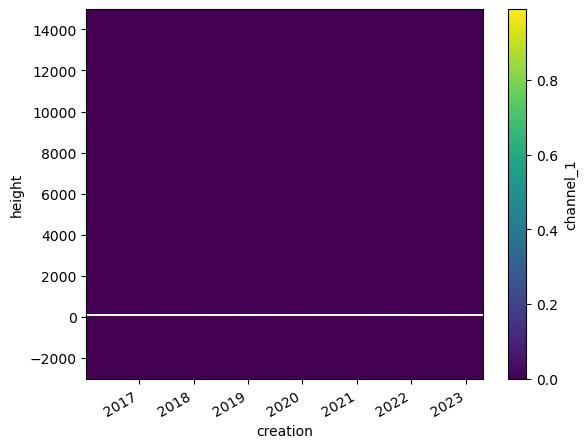

In [9]:
ds_concat.channel_1.where(ds_concat.channel_1 < 1).plot(x='creation')

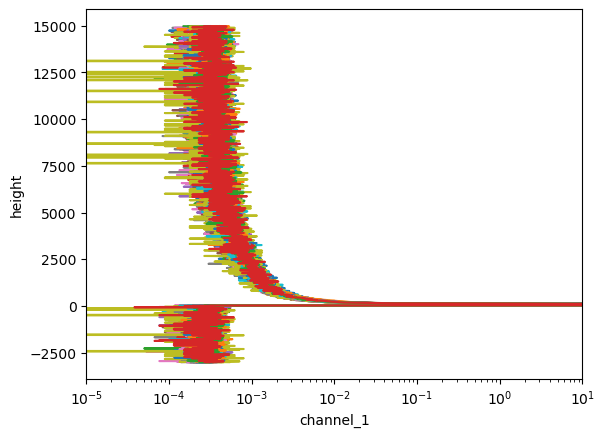

In [26]:
ds_concat.channel_1.plot(y='height',hue='creation',xscale='log',add_legend=False,xlim=[1e-5,10])

In [21]:
# apply vertical smoothing to profiles...

def smooth_rollingaverage(signal, nk=20):
    return np.convolve(signal, np.ones(nk)/nk, mode='same')

ds_concat['smooth_1'] = xr.apply_ufunc(smooth_rollingaverage, # function to use
                ds_concat.channel_1, # list of arguments to above function
                input_core_dims=[['height']], # dimension(s) that designate eavh input vector to func
                output_core_dims=[['height']],
                vectorize=True) # applys function with all combinations of non-core dimensions
ds_concat

<xarray.Dataset>
Dimensions:    (creation: 64, height: 1200)
Coordinates:
  * creation   (creation) datetime64[ns] 2016-01-26T13:38:00 ... 2023-04-12T1...
  * height     (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables:
    channel_1  (creation, height) float32 0.00032 0.0002533 ... 0.0002667
    channel_2  (creation, height) float32 0.00024 0.0002 ... 0.0003429 0.0001905
    E0         (creation) float32 5.17 5.258 5.372 5.497 ... 4.982 4.707 4.431
    smooth_1   (creation, height) float64 0.000118 0.000134 ... 0.0002 0.0001829

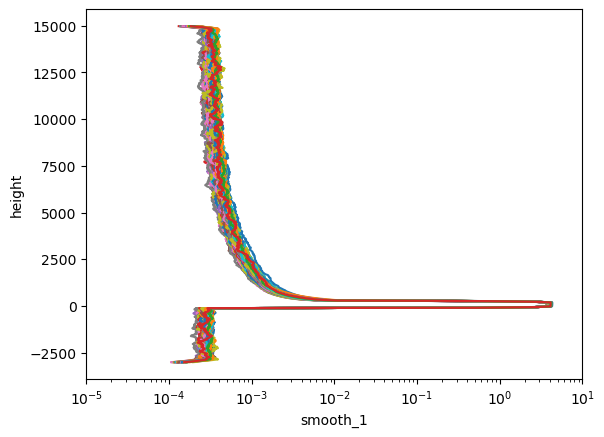

In [27]:
ds_concat.smooth_1.plot(y='height',hue='creation',xscale='log',add_legend=False,xlim=[1e-5,10])

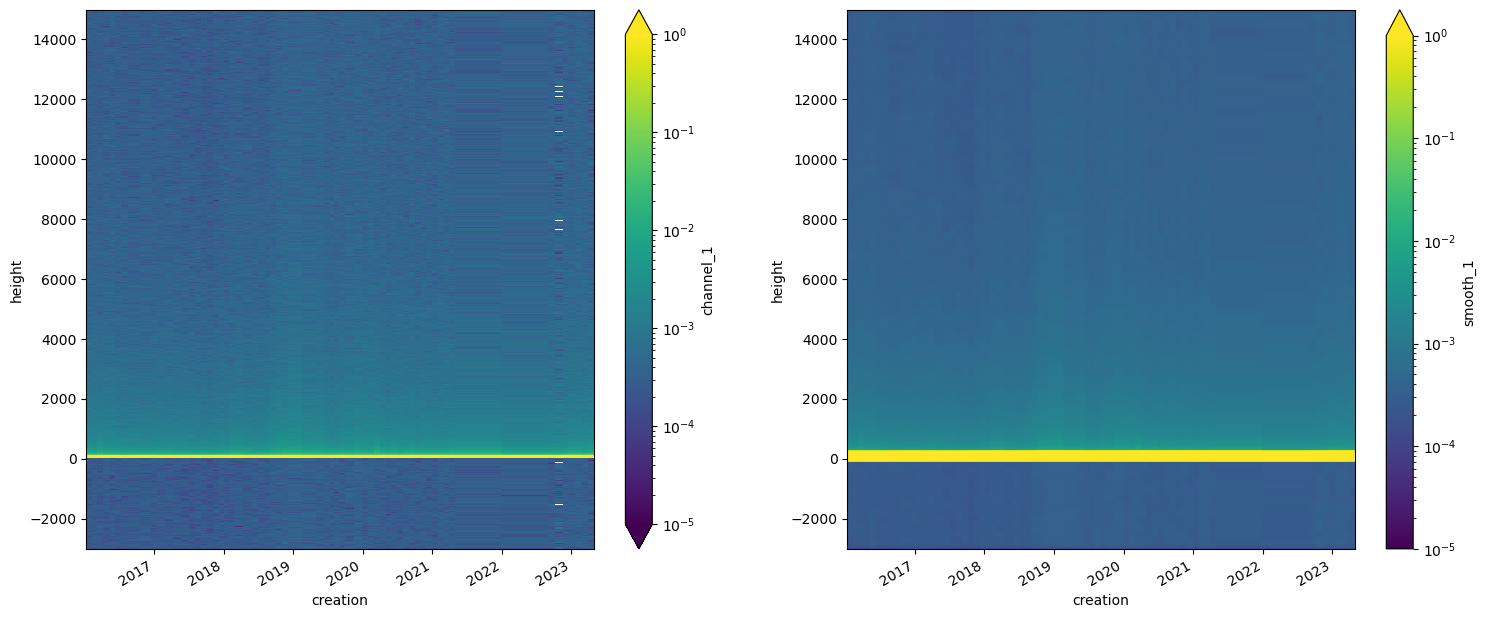

In [33]:
import matplotlib.colors as colors

fig,axs = plt.subplots(1,2,figsize=(18,7))

ds_concat.channel_1.plot(x='creation',y='height',norm=colors.LogNorm(vmin=1e-5,vmax=1),ax=axs[0])
ds_concat.smooth_1.plot(x='creation',y='height',norm=colors.LogNorm(vmin=1e-5,vmax=1),ax=axs[1])

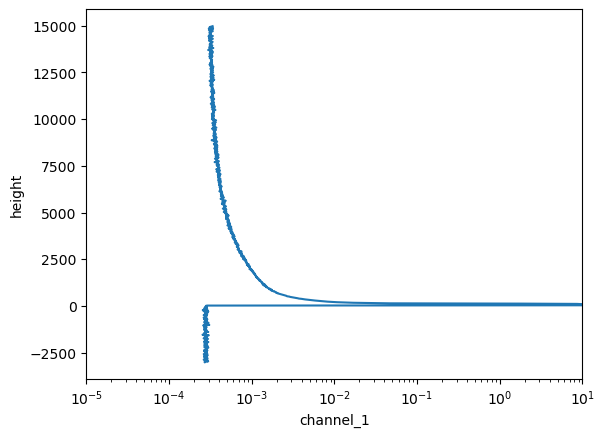

In [35]:
ds_concat.channel_1.mean(dim='creation').plot(y='height',xlim=[1e-5,10],xscale='log')

In [37]:
# produce dataset to save, as afterpulse signal
ds_save = ds_concat.mean(dim='creation')
ds_save

<xarray.Dataset>
Dimensions:    (height: 1200)
Coordinates:
  * height     (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables:
    channel_1  (height) float32 0.0002708 0.0002729 ... 0.0003315 0.0003362
    channel_2  (height) float32 0.0002816 0.0002641 ... 0.0003418 0.0003433
    E0         float32 4.945

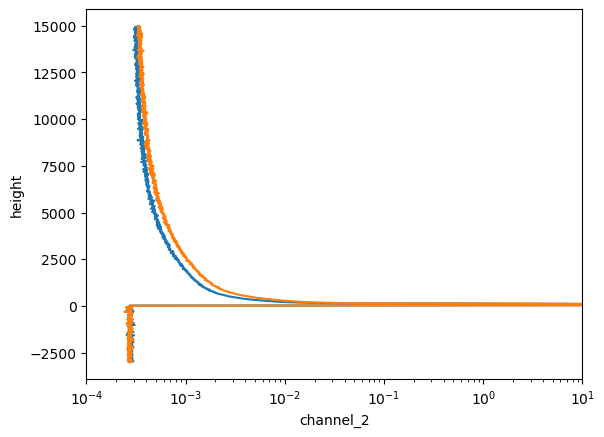

In [38]:
ds_save.channel_1.plot(y='height',xscale='log', xlim=[1e-4,10])
ds_save.channel_2.plot(y='height')

In [39]:
ds_save.to_netcdf('afterpulse.cdf')